In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal

# if torch.cuda.is_available():
#     DEVICE = 'cuda'
#     GPU_DEVICE = 2
#     torch.cuda.set_device(GPU_DEVICE)
# else:
#     DEVICE='cpu'
DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# <center>Deep Generative Models</center>
## <center>Seminar 4</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>03.10.2022</center>


## Plan

1. Latent Variable Modeling

    - Gaussian Mixture Models (GMM)
    
    - MLE for GMM
    
2. ELBO and EM - algorithm. 
    
    - EM algorithm for GMM (theory and practice)
    
    - EM algorithm for probabilistic PCA (theory) <span style="color:red"> No! </span>

3. VAE
    

## Latent Variables Model

<center><img src="pics/lvm_diagram.png" width=600 /></center>

**Advantages**

1. Latent space could describe high-level features of the data:

<center><img src="pics/celeba_interpolation.png" width=300 /></center>

2. the distributions $p(x | z)$ and $p(z)$ could be rather simple:
    
    * Example: $p(x|z) = \mathcal{N}(\boldsymbol{\mu}(z), \boldsymbol{\Sigma}(z))$, $p(z) = \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$
    
3. It is beneficial to model $p(z | x)$

<center><img src="pics/image_restoration.png" width=300 /></center>


**Likelihood**

$p(x |\theta) = \int\limits_{\mathcal{Z}} p(x | z, \theta) p(z| \theta) dz$

**Sampling procedure**

* Sample $z^* \sim p(z | \theta)$

* Sample $x \sim p(x | z^*, \theta)$

### Gaussian Mixture Models

$p(z | \theta) = \text{Categorical}(\pi_1, \dots \pi_k)$

$p(\boldsymbol{x} | z, \theta) = \mathcal{N}\left(\boldsymbol{x}|, \boldsymbol{\mu}_z, \boldsymbol{\Sigma}_z\right)$

**Likelihood** of the model?

$p(x | \theta) = \sum\limits_{i = 1}^{k}  \pi_i \mathcal{N}\left(x - \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i\right)$

**Note:** Можно создавать параметры модели следующим образом!: 

```python
self.param = nn.Parameter(param)
```

Поскольку  `__setattr__` переопредлён!

In [2]:
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

In [3]:
class GMM(nn.Module):
    
    @property
    def mu(self):
        return self._mu
    
    @mu.setter
    def mu(self, val):
        self._mu = nn.Parameter(val)

    @property
    def sigma(self):
        return self._L @ self._L.transpose(1, 2)
    
    @sigma.setter
    def sigma(self, val):
        self._L = nn.Parameter(torch.cholesky(val))

    @property
    def pi(self):
        return F.softmax(self._log_pi)

    @pi.setter
    def pi(self, val):
        assert val.min() > 0.
        val = val/torch.sum(val)
        self._log_pi = nn.Parameter(torch.log(val))

    @property
    def gmm(self):
        mix = TD.Categorical(self.pi)
        mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self._L)
        gmm = TD.MixtureSameFamily(mix, mv_normals)
        return gmm

    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (K, dim)
                       (default) random from uniform[-10, 10]
            - sigma: covariance matrices of clusters (K, dim, dim)
                          (default) Identity matrix for each cluster
            - pi: cluster weights (K,)
                       (default) equal value to all cluster i.e. 1/K
        '''
        super().__init__()
        self.K = K
        self.dim = dim
        if mu is None:
            mu = np.random.rand(K, dim)*20 - 10
        self.mu = torch.tensor(mu)
        if sigma is None :
            sigma = np.zeros((K, dim, dim))
            for i in range(K):
                sigma[i] = np.eye(dim)
        self.sigma = torch.tensor(sigma)
        assert torch.allclose(self.sigma, torch.tensor(sigma))
        if pi is None:
            pi = np.ones(self.K)/self.K
        self.pi = torch.tensor(pi)
        # mix = TD.Categorical(self.pi)
        # mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self.sigma)
        # self.gmm = TD.MixtureSameFamily(mix, mv_normals)
        # self.gmm = TD.MultivariateNormal(self.mu, self.sigma)

    def log_prob(self, X):
        '''
        Compute the log-prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: log Sum_k pi_k * N( X_i | mu_k, sigma_k ))
        '''
        return self.gmm.log_prob(X)

    def prob(self, X):
        '''
        Computes the prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: Sum_k pi_k * N( X_i | mu_k, sigma_k )
        '''
        return torch.exp(self.log_prob(X))
    
    def prob_X_Zs(self, X):
        '''
        Computes the matrix of probabilities p(X, Z | \theta)
        for all possible Z_i \in \{1, 2, \dots K\}
        :Parameters:
        X : tensor (N, D)
        :Output:
        out : tensor (N, K)
        '''
        mv_normals = self.gmm._component_distribution
        X_expanded = X.unsqueeze(-2).repeat(1, self.K, 1) # (N, K, 2)
        log_probs_unw = mv_normals.log_prob(X_expanded) # (N, K)
        log_probs_w = torch.exp(log_probs_unw) * self.pi.unsqueeze(0) # (N, K)
        return log_probs_w

    def sample(self, shape):
        return self.gmm.sample(shape)

class GMM_MLEgrad(GMM):

    def loss(self, x):
        # self._project()
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}

GMM visualization

In [4]:
def draw_contour(density, X, Y, title, n_levels=3):
    plt.figure(figsize=(5, 5))
    density = density.reshape(X.shape)
    levels = np.linspace(np.min(density), np.max(density), n_levels)
    plt.contour(X, Y, density, levels=levels, c='red')
    plt.title(title, fontsize=16)
    plt.show()

def draw_distrib(distrib, title, n_levels=20, x_lim=(-11, 11), y_lim=(-11, 11), dx=0.1, dy=0.1, device=DEVICE, contour=True, density=True):
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    densities = torch.exp(distrib.log_prob(torch.tensor(mesh_xs).to(device))).detach().cpu().numpy()
    if contour:
        draw_contour(densities, x, y, title='{} contour'.format(title), n_levels=20)
    if density:
        visualize_2d_densities(x, y, densities, title='{} pdf'.format(title))

#### Task setup

The distribution we will work with:

In [5]:
class FlowerGMM(GMM):

    def __init__(self):
        CENTERS_SCALE = 6.
        MAJOR_VAR = 3.
        MINOR_VAR = 1.
        r_angles = np.linspace(0., 2 * np.pi, 7, endpoint=False)
        vs = np.array([[np.cos(ang), np.sin(ang)] for ang in r_angles])
        perp_vs = np.array([[-np.sin(ang), np.cos(ang)] for ang in r_angles])
        mus = np.array([[0., 0.],] + [CENTERS_SCALE * v for v in vs])
        R_matrices = np.stack([vs, perp_vs], axis=1)
        petal_sigmas = np.array([[MAJOR_VAR, 0.], [0., MINOR_VAR]])[np.newaxis,...].repeat(7, axis=0)
        sigmas = np.concatenate([
            np.eye(2)[np.newaxis,...], 
            R_matrices.transpose(0, 2, 1) @ petal_sigmas @ R_matrices])
        super().__init__(8, 2, mu=mus, sigma=sigmas)
        # super().__init__(1, 2)

Visualization of `FlowerGMM`

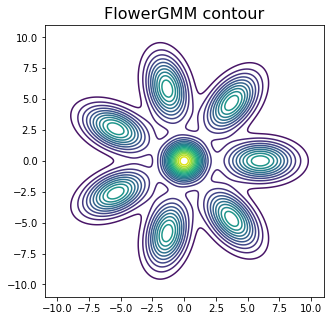

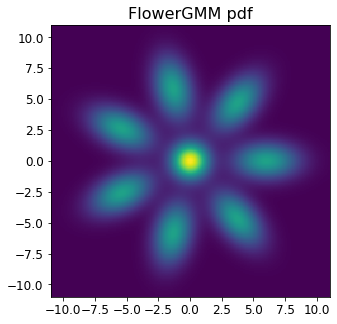

In [41]:
fgmm = FlowerGMM().to(DEVICE)
draw_distrib(fgmm, 'FlowerGMM')

Reference samples from `FlowerGMM`

In [42]:
torch.manual_seed(42)
train_data = fgmm.sample((20000,)).detach()
test_data = fgmm.sample((2000,)).detach()

**Question.**

How to fit GMM model to data $X_1, \dots X_n$ from unknown distribution?

- One can try likelihood maximization

- EM algorithm (will be explained soon)

### GMM via MLE

Let $X_1, \dots, X_n \sim p(x)$ , $X_i \in \mathbb{R}^D$

**GMM** model likelihood: 

$\log p(\boldsymbol{X} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum\limits_{j = 1}^{n} \log \left(\sum\limits_{i = 1}^{k}  \pi_i \mathcal{N}\left(X_j - \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i\right)\right)$

Analytical solution is **hard**! $\Rightarrow$ gradient optimization

In [9]:
class GMM_MLEgrad(GMM):

    def loss(self, x):
        # self._project()
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}

Initialize a GMM model which will be trained

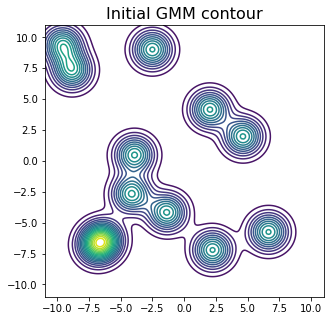

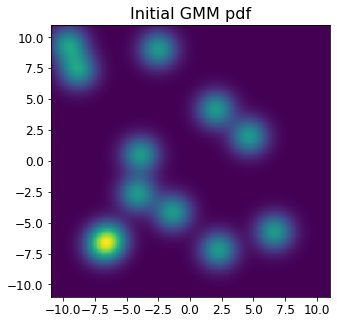

In [10]:
np.random.seed(42)
N_COMPONENTS = 12
gmm = GMM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmm, 'Initial GMM')

In [311]:
BATCH_SIZE = 128
LR= 1e-3
EPOCHS = 100
USE_CUDA=True

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    gmm, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA
)

  0%|          | 0/100 [00:00<?, ?it/s]

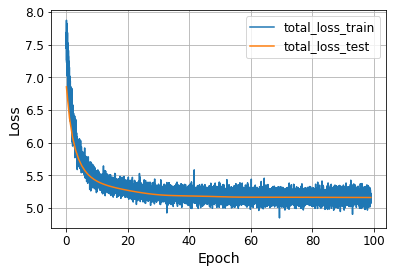

In [312]:
plot_training_curves(train_losses, test_losses)

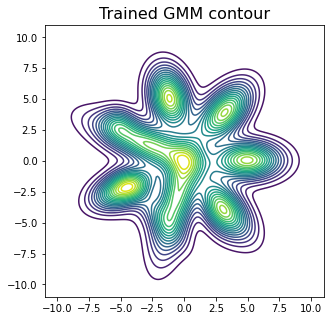

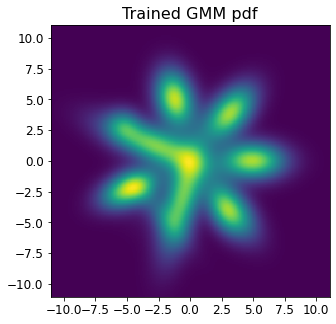

In [313]:
draw_distrib(gmm, 'Trained GMM')

## ELBO

<center><img src="pics/elbo.png" width=600 /></center>

## EM-algorithm

<center><img src="pics/em.png" width=600 /></center>

### GMM via EM - algorithm

$\theta = \{ \boldsymbol{\pi}_{1:K}, \boldsymbol{\mu}_{1:K}, \boldsymbol{\Sigma}_{1:K} \}$

**E-step**

$\xi_{k}^{n} = p\left( \{ z_n = k \} \middle| X_n, \theta^{\text{prev}}\right) = \frac{p\left(X_n \,\middle| \,\{ z_n = k\}, \theta^{\text{prev}}\right) p\left(\{ z_n = k\}\middle| \theta^{\text{prev}}\right)}{\sum\limits_{k' = 1}^{K} p\left(X_n \,\middle| \,\{ z_n = k'\}, \theta^{\text{prev}}\right) p\left(\{ z_n = k'\} \middle| \theta^{\text{prev}}\right)}$

**M-step**

$\pi^{\text{new}}_k = \frac{1}{N} \sum\limits_{n = 1}^{N} \xi_k^n \, \in \, (0, 1)$

$\mu^{\text{new}}_k = \frac{1}{\sum\limits_{n = 1}^{N} \xi_k^n} \sum\limits_{n = 1}^{N} \xi_{k}^{n} X_n \, \in \, \mathbb{R}^D$

$\Sigma^{\text{new}}_k = \frac{1}{\sum\limits_{n = 1}^{N} \xi_k^n} \sum\limits_{n = 1}^{N} \xi_{k}^{n} \left(X_n - \mu^{\text{new}}_k\right) \left(X_n - \mu^{\text{new}}_k\right)^T \in \text{PSD}\left(\mathbb{R}^{D \times D}\right)$

In [12]:
# K is number of components in the Gaussian Mixture Model
# N is the number of samples |X|
# D=2 is the dimension of each sample X_n

class GMM_EM(GMM):
    
    def prob_components(self, X):
        '''
        Creates matrix of p(z_k | X_n, \theta)
        :Parameters:
        X : tensor (N, 2) : samples from the target distribution
        '''
        p_x_zs = self.prob_X_Zs(X)
        return p_x_zs / p_x_zs.sum(-1, keepdim=True)
    
    def compute_pi_new(self, prob_components):
        '''
        Computes the paramters \pi_{new} at the M-step of EM algo
        :Parameters:
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        :Output:
        pi_new : tensor (K,) : \pi_{new} 
        '''
        return torch.mean(prob_components, dim=0)
    
    def compute_mu_new(self, X, prob_components):
        '''
        Computes the parameters \mu_{new} at the M-step of EM algo
        :Paramters:
        X : tensor (N, 2) : samples from the target distribution
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        :Output:
        mu_new : tensor (K, 2) : \mu_{new}
        '''
        X_expanded = X.unsqueeze(-2) # (N, 1, 2)
        prob_components_expanded = prob_components.unsqueeze(-1) # (N, K, 1)
        mu_unnorm = torch.sum(X_expanded * prob_components_expanded, dim=0) # (K, 2)
        return mu_unnorm / prob_components_expanded.sum(0)
    
    def compute_sigma_new(self, X, mu_new, prob_components):
        '''
        :Parameters:
        X : tensor (N, 2) : samples from the target distribution
        mu_new : tensor (K, 2) : \mu_{new} from the M-step of EM algo
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        '''
        X_expanded = X.unsqueeze(-2) # (N, 1, 2)
        mu_new_expanded = mu_new.unsqueeze(0) # (1, K, 2)
        X_min_mu = X_expanded - mu_new_expanded # (N, K, 2)
        X_min_mu_expanded = X_min_mu.unsqueeze(-2) # (N, K, 1, 2)
        Cov_grid = X_min_mu_expanded.transpose(-1, -2) @ X_min_mu_expanded # (N, K, 2, 2)
        prob_components_expanded = prob_components.unsqueeze(-1).unsqueeze(-1) # (N, K, 1, 1)
        Sigma_unnorm = torch.sum(prob_components_expanded * Cov_grid, dim=0) # (K, 2, 2)
        return Sigma_unnorm / prob_components_expanded.sum(0)
    
def EM_step(gmm_em, X):
    gmm_em.eval()
    # E step
    with torch.no_grad():
        prob_components = gmm_em.prob_components(X)
    
    # M step
    with torch.no_grad():
        pi_new = gmm_em.compute_pi_new(prob_components)
        mu_new = gmm_em.compute_mu_new(X, prob_components)
        Sigma_new = gmm_em.compute_sigma_new(X, mu_new, prob_components)
    
    # update parameters
    eps=1e-5
    gmm_em.pi = pi_new 
    gmm_em.mu = mu_new
    gmm_em.sigma = Sigma_new + torch.eye(Sigma_new.size(-1)).unsqueeze(0).repeat(Sigma_new.size(0), 1, 1) * eps

Initialize the gmm distribution to be trained with `EM`-algo

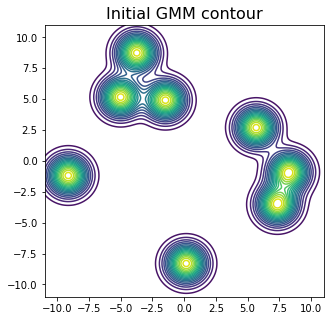

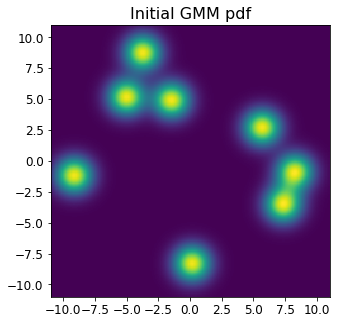

In [13]:
np.random.seed(46)
N_COMPONENTS = 8
gmm = GMM_EM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmm, 'Initial GMM')

Launch the `EM` - algorithm

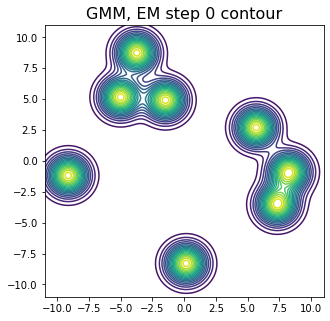

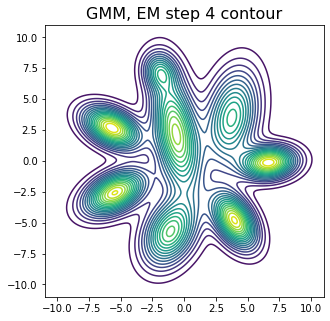

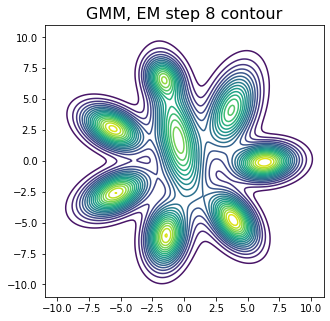

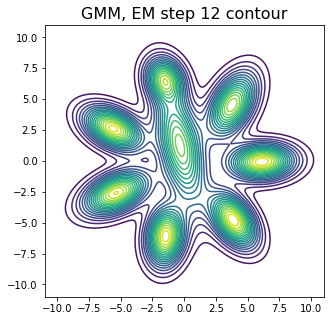

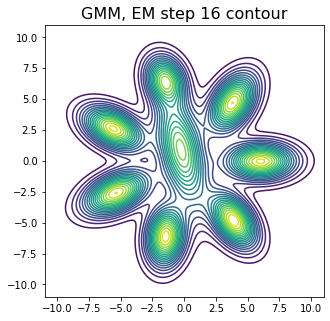

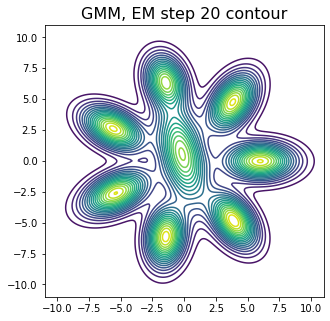

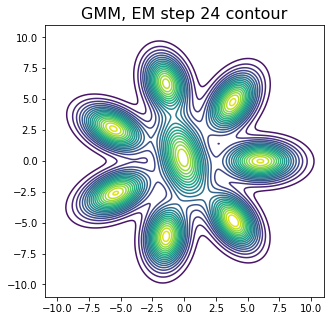

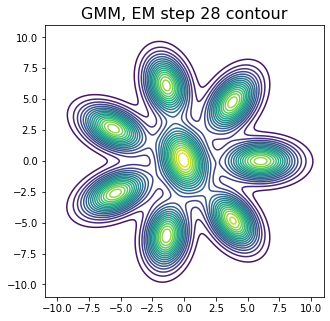

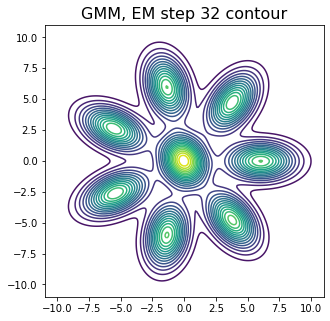

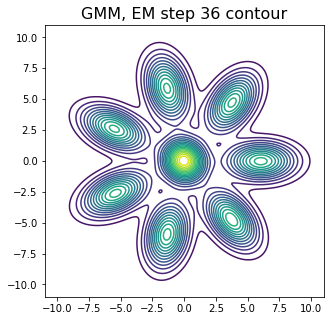

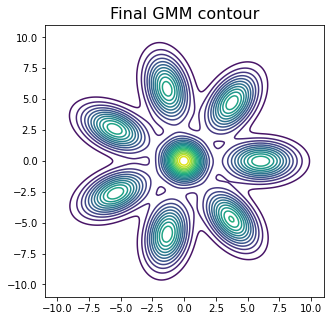

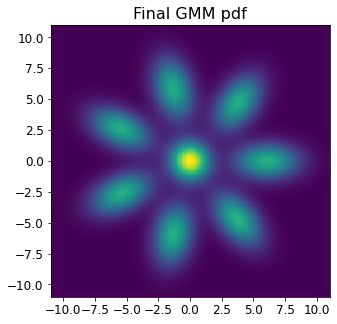

In [14]:
N_EM_STEPS = 40

for n_step in range(N_EM_STEPS):
    if n_step % 4 == 0:
        draw_distrib(gmm, 'GMM, EM step {}'.format(n_step), density=False)
    EM_step(gmm, train_data)
draw_distrib(gmm, 'Final GMM')

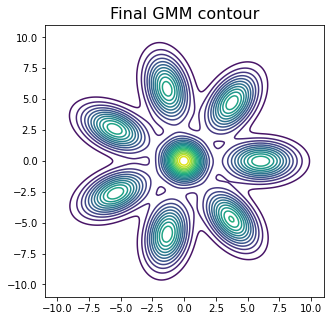

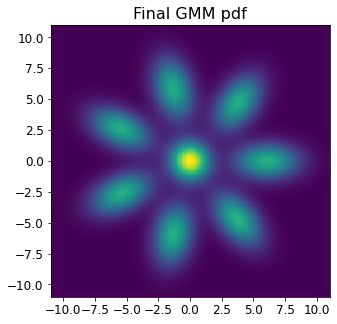

In [15]:
draw_distrib(gmm, 'Final GMM')

### GMM via Variational EM

Let $\boldsymbol{X} = X_1, \dots, X_N$ is the sample from unknown distribution

We are looking for the distribution $q(z | x, \phi)$ and $\theta = \{ \boldsymbol{\pi}_{1:K}, \boldsymbol{\mu}_{1:K}, \boldsymbol{\Sigma}_{1:K} \}$ which maximizes the **ELBO** functional:

$$
L(q, \theta) = \int\limits_{\boldsymbol{Z}} q(\boldsymbol{z} | \boldsymbol{X}, \phi) \log \frac{p(\boldsymbol{X}| \boldsymbol{z}, \theta)p(\boldsymbol{z} | \theta)}{q(\boldsymbol{z} | \boldsymbol{X}, \phi)} d \boldsymbol{z} = \sum\limits_{n = 1}^{N} \int\limits_{z_n} q(z_n | X_n, \phi) \log \frac{p(X_n | z_n, \theta) p(z_n | \theta)}{q(z_n | X_n, \phi)} d z_n =\\=
\sum\limits_{n = 1}^{N} \left(\int\limits_{z_n} q(z_n | X_n, \phi) \log p(X_n, z_n | \theta) d z_n - \int\limits_{z_n} q(z_n | X_n, \phi) \log q(z_n | X_n, \phi) d z_n\right)
$$

**E-step**

$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}}$

**M-step**

$\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} L(q(\cdot| \boldsymbol{X}, \phi_{k + 1}), \theta)|_{\theta=\theta_{k}}$

In [16]:
class GMM_VariationalEM(nn.Module):
    
    @staticmethod
    def freeze(model):
        for p in model.parameters():
            p.requires_grad_(False)
        model.eval()    
    
    @staticmethod
    def unfreeze(model):
        for p in model.parameters():
            p.requires_grad_(True)
        model.train(True)
    
    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (K, dim)
            - sigma: covariance matrices of clusters (K, dim, dim)
            - pi: cluster weights (K,)
        '''
        super().__init__()
        self.gmm_model = GMM(K, dim, mu, sigma, pi)
        self.q = nn.Sequential(
            nn.Linear(dim, max(100, 2*dim, 2*K)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 2*dim, 2*K), max(100, 4*dim, 4*K)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 4*dim, 4*K), max(100, 2*dim, 2*K)),
            nn.ReLU(True),
            nn.Linear(max(100, 2*dim, 2*K), K),
            nn.Softmax())
    
    def ELBO_objective(self, X, with_entropy=False, reduction='sum'):
        '''
        Returns the full ELBO objective
        :Parameters:
        X : tensor (bs, D) : batch of samples
        '''
        eps = 1e-8
        assert reduction in ['sum', 'mean']
        def reduction_func(x):
            return torch.sum(x) if reduction == 'sum' else torch.mean(x)
        
        Z_probs = self.q(X) # (bs, K)
        log_p_x_zs = torch.log(self.gmm_model.prob_X_Zs(X)) # (bs, K)
        if torch.isnan(log_p_x_zs).any():
            print('log_p_x_zs has nan!')
        elbo_without_entropy_components = torch.sum(Z_probs * log_p_x_zs, dim=-1) # (bs,)
        
        if torch.isnan(elbo_without_entropy_components).any():
            print('elbo without entropy has nan!')
        
        if not with_entropy:
            return reduction_func(elbo_without_entropy_components)
        
        H_components = torch.sum( - Z_probs * torch.log(Z_probs + eps), dim=-1) # (bs,)
        if torch.isnan(H_components).any():
            print('H_components has nan!')
        elbo_components = elbo_without_entropy_components + H_components
        if torch.isnan(elbo_components).any():
            print('elbo has nan!')
        
        return reduction_func(elbo_components)
    
    def E_step_loss(self, X):
        self.freeze(self.gmm_model)
        self.unfreeze(self.q)
        return - self.ELBO_objective(X, with_entropy=True, reduction='mean')
    
    def M_step_loss(self, X):
        self.freeze(self.q)
        self.unfreeze(self.gmm_model)
        return - self.ELBO_objective(X, with_entropy=False, reduction='mean')
        
        

def train_GMM_VariationalEM(
    gmmEMVar, 
    train_loader, 
    epochs=20, 
    E_grad_steps = 1,
    M_grad_steps = 1,
    q_lr=1e-3, 
    gmm_model_lr=1e-3, 
    use_tqdm=True, 
    use_cuda=False):
    
    def steps_counter():
        curr_step = 'E'
        steps_passed = 0
        while True:
            steps_passed += 1
            if curr_step == 'E':
                if steps_passed > E_grad_steps:
                    curr_step = 'M'
                    steps_passed = 1
            elif curr_step == 'M':
                if steps_passed > M_grad_steps:
                    curr_step = 'E'
                    steps_passed = 1
            yield curr_step
    
    SC = steps_counter()
                
    q_optimizer = optim.Adam(gmmEMVar.q.parameters(), lr=q_lr)
    gmm_model_optimizer = optim.Adam(gmmEMVar.gmm_model.parameters(), lr=gmm_model_lr)

    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    
    if use_cuda:
        gmmEMVar = gmmEMVar.cuda()

    for epoch in forrange:
        
        if epoch % 4 == 0:
            # clear_output(wait=True)
            draw_distrib(gmmEMVar.gmm_model, 'GMM_EM_variational, epoch {}'.format(epoch), density=False)
        
        for x in train_loader:
            if use_cuda:
                x = x.cuda()
            x = x.type(torch.FloatTensor)

            # E step
            if next(SC) == 'E':
                q_optimizer.zero_grad()
                E_loss = gmmEMVar.E_step_loss(x)
                E_loss.backward()
                q_optimizer.step()

            # M step
            else:
                gmm_model_optimizer.zero_grad()
                M_loss = gmmEMVar.M_step_loss(x)
                M_loss.backward()
                gmm_model_optimizer.step()

Initialize the gmm distribution to be trained with `Variational EM`-algo

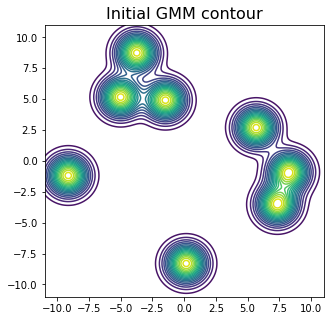

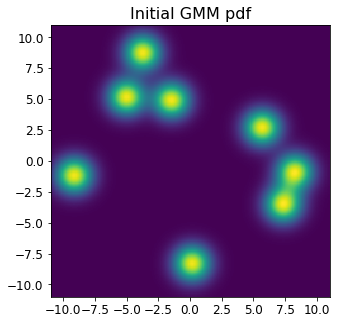

In [17]:
np.random.seed(46)
N_COMPONENTS = 8
gmmEMVar = GMM_VariationalEM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmmEMVar.gmm_model, 'Initial GMM')

Launch the `Variational EM` algo

  0%|          | 0/20 [00:00<?, ?it/s]

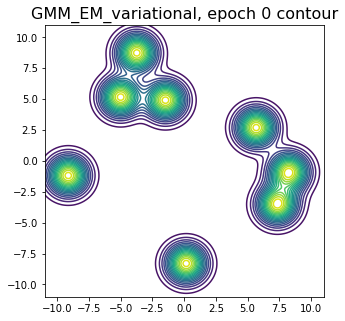

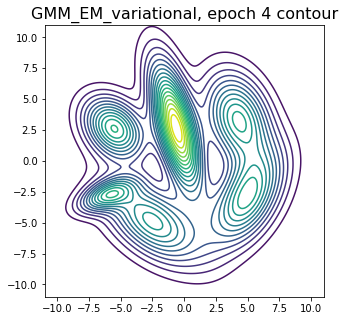

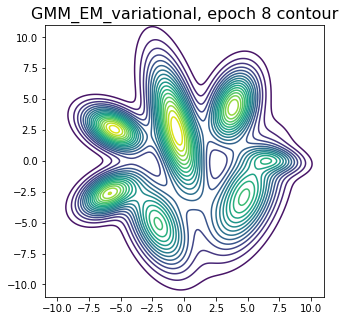

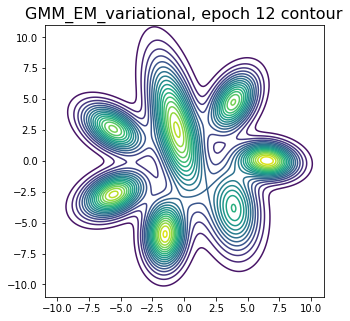

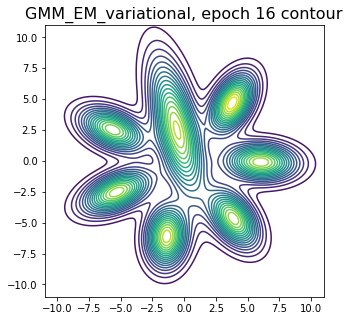

In [18]:
EPOCHS = 20
BATCH_SIZE = 32
Q_LR = 1e-3 # < 1e-2
GMM_LR = 1e-2
E_GRAD_STEPS = 100
M_GRAD_STEPS = 100

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)



train_GMM_VariationalEM(
    gmmEMVar, train_loader, EPOCHS, E_GRAD_STEPS, M_GRAD_STEPS, Q_LR, GMM_LR, use_tqdm=True)

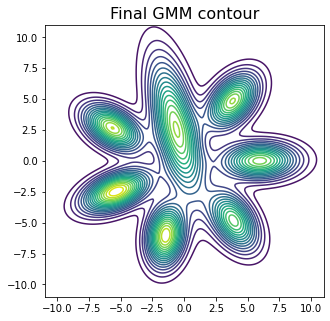

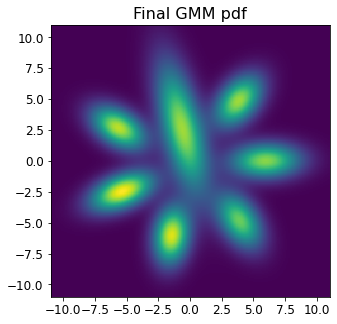

In [19]:
draw_distrib(gmmEMVar.gmm_model, 'Final GMM')

### GMM with fixed prior $p(z)$ via Variational EM

Let $\boldsymbol{X} = X_1, \dots, X_N$ is the sample from unknown distribution

* Now we consider the distribution of $z$ to be **fixed** (it does not depend on optimized parameters):
$$
p(z|\theta) \longrightarrow p(z)
$$

* The parameters <span style="color:red"> $\theta$ are now interpreted as the **parameters of NN** </span>, which predicts `mean` and `covariance` of the Multivariate normal distribution $p(X|z, \theta)$

**ELBO** functional:

$$
L(q, \theta) = \int\limits_{\boldsymbol{Z}} q(\boldsymbol{z} | \boldsymbol{X}, \phi) \log \frac{p(\boldsymbol{X}| \boldsymbol{z}, \theta)p(\boldsymbol{z})}{q(\boldsymbol{z} | \boldsymbol{X}, \phi)} d \boldsymbol{z} = \sum\limits_{n = 1}^{N} \int\limits_{z_n} q(z_n | X_n, \phi) \log \frac{p(X_n | z_n, \theta) p(z_n)}{q(z_n | X_n, \phi)} d z_n =\\= \sum\limits_{n = 1}^{N} \left(\int\limits_{z_n} q(z_n | X_n, \phi) \log p(X_n | z_n, \theta) d z_n + \int\limits_{z_n} q(z_n | X_n, \phi) \log \frac{p(z_n)}{q(z_n | X_n, \phi)} d z_n\right) =\\=
\sum\limits_{n = 1}^{N} \left( E_{z_n \sim q(z_n | X_n, \phi)} \big{(}\log p(X_n | z_n, \theta)\big{)} - KL\big{(}q(z_n | X_n, \phi) || p(z_n)\big{)}\right)
$$

**E-step**

$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}}$

**M-step**

$\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} L(q(\cdot| \boldsymbol{X}, \phi_{k + 1}), \theta)|_{\theta=\theta_{k}}$

In [162]:
class PTheta(nn.Module):
    
    def __init__(self, K, dim):
        super().__init__()
        self.K = K
        self.dim = dim
        self.L_dim = int((dim * (dim + 1)) / 2.)
        
        self.hidden_net = nn.Sequential(
            nn.Linear(K, max(100, 2*K, 2*dim)),
#             nn.ReLU(True),
#             nn.Dropout(0.005),
#             nn.Linear(max(100, 2*K, 2*dim), max(100, 4*K, 4*dim)),
#             nn.ReLU(True),
#             nn.Dropout(0.005),
#             nn.Linear(max(100, 4*K, 4*dim), max(100, 2*K, 2*dim)),
            nn.ReLU(True))
        
        self.mu_net = nn.Sequential(
            nn.Linear(max(100, 2*K, 2*dim), max(100, 2*K, 2*dim)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 2*K, 2*dim), dim))
        
        self.L_net = nn.Sequential(
            nn.Linear(max(100, 2*K, 2*dim), max(100, 2*self.L_dim)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 2*self.L_dim), self.L_dim))
    
    def forward(self, z):
        '''
        :Parameters:
        z: tensor (bs, K) in one-hot format
        :Outputs:
        mu : tensor (bs, D) : mean of distribution
        L : tensor (bs, D , D) : scale tril matrix of distribution
        '''
        hid = self.hidden_net(z)
        mu = self.mu_net(hid) # (bs, D)
        L_raw = self.L_net(hid) # (bs, D*(D + 1)/2)
        L = torch.zeros((z.size(0), mu.size(1), mu.size(1))).to(L_raw)
        tril_indices = torch.tril_indices(row=mu.size(1), col=mu.size(1), offset=0)
        L[:,tril_indices[0], tril_indices[1]] = L_raw
        L[:, torch.arange(self.dim), torch.arange(self.dim)] = torch.exp(L[:, torch.arange(self.dim), torch.arange(self.dim)])
        return mu * 100, L
    
    def prob_X_given_Zs(self, X):
        oh_z_categories = F.one_hot(torch.arange(self.K)).type(torch.FloatTensor).requires_grad_() #(K, K)
        mu, L = self(oh_z_categories) # (K, 2), (K, 2, 2)
        mv_normals = TD.MultivariateNormal(mu, scale_tril=L)
        
        X_expanded = X.unsqueeze(-2).repeat(1, self.K, 1) # (N, K, 2)
        log_probs = mv_normals.log_prob(X_expanded)
        if torch.isnan(log_probs).any():
            print('log_p_x_zs has nan!')
        return torch.exp(mv_normals.log_prob(X_expanded)) # (N, K)

class GMM_VariationalEMFixedPrior(nn.Module):
    
    @property
    def gmm_model(self):
        with torch.no_grad():
            oh_z_categories = F.one_hot(torch.arange(self.K)).type(torch.FloatTensor) #(K, K)
            mu, L = self.p_theta(oh_z_categories) # (K, 2), (K, 2, 2)
            mu = mu.type(torch.DoubleTensor)
            L = L.type(torch.DoubleTensor)
#             print('mu:', mu)
#             print('L:', L)
            #  K, dim, mu=None, sigma=None, pi=Non
            gmm = GMM(self.K, self.dim, mu=mu, sigma=None, pi=self.pi)
            gmm._L = torch.nn.Parameter(L)
        return gmm
    
    @staticmethod
    def freeze(model):
        for p in model.parameters():
            p.requires_grad_(False)
        model.eval()    
    
    @staticmethod
    def unfreeze(model):
        for p in model.parameters():
            p.requires_grad_(True)
        model.train(True)
    
    def __init__(self, K, dim, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - pi: cluster weights (K,)
        '''
        super().__init__()
        self.K = K
        self.dim = dim
        # q is q(z|x, \phi) model
        self.q = nn.Sequential(
            nn.Linear(dim, max(100, 2*dim, 2*K)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 2*dim, 2*K), max(100, 4*dim, 4*K)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 4*dim, 4*K), max(100, 2*dim, 2*K)),
            nn.ReLU(True),
            nn.Linear(max(100, 2*dim, 2*K), K),
            nn.Softmax())
        
        # p_theta is p(x | z, \theta) model
        self.p_theta = PTheta(K, dim)
        
        # pi is fixed tensor
        if pi is None:
            pi = np.ones(K)/K
        self.pi = torch.tensor(pi)
    
    def ELBO_objective(self, X, with_KL=False, reduction='sum'):
        '''
        Returns the full ELBO objective
        :Parameters:
        X : tensor (bs, D) : batch of samples
        '''
        eps = 1e-8
        assert reduction in ['sum', 'mean']
        def reduction_func(x):
            return torch.sum(x) if reduction == 'sum' else torch.mean(x)
        
        Z_probs = self.q(X) # (bs, K)
        val = self.p_theta.prob_X_given_Zs(X)
        log_p_x_given_zs = torch.log(self.p_theta.prob_X_given_Zs(X) + eps) # (bs, K)
        
        elbo_without_KL_components = torch.sum(Z_probs * log_p_x_given_zs, dim=-1) # (bs,)
        
        if not with_KL:
            return reduction_func(elbo_without_KL_components)
        
        # compute KL divergence between q(z|X, \theta) and p(z)
        KL_components = torch.sum( Z_probs *(torch.log(self.pi) - torch.log(Z_probs + eps)), dim=-1) # (bs,)
        elbo_components = elbo_without_KL_components + KL_components
        
        return reduction_func(elbo_components)
    
    def E_step_loss(self, X):
        self.freeze(self.p_theta)
        self.unfreeze(self.q)
        return - self.ELBO_objective(X, with_KL=True, reduction='mean')
    
    def M_step_loss(self, X):
        self.freeze(self.q)
        self.unfreeze(self.p_theta)
        return - self.ELBO_objective(X, with_KL=False, reduction='mean')
        

def train_GMM_VariationalEMFixedPrior(
    gmmEMVar, 
    train_loader, 
    epochs=20, 
    E_grad_steps = 1,
    M_grad_steps = 1,
    q_lr=1e-3, 
    gmm_model_lr=1e-3, 
    use_tqdm=True, 
    use_cuda=False):
    
    def steps_counter():
        curr_step = 'E'
        steps_passed = 0
        while True:
            steps_passed += 1
            if curr_step == 'E':
                if steps_passed > E_grad_steps:
                    curr_step = 'M'
                    steps_passed = 1
            elif curr_step == 'M':
                if steps_passed > M_grad_steps:
                    curr_step = 'E'
                    steps_passed = 1
            yield curr_step
    
    SC = steps_counter()
                
    q_optimizer = optim.Adam(gmmEMVar.q.parameters(), lr=q_lr)
    gmm_model_optimizer = optim.Adam(gmmEMVar.p_theta.parameters(), lr=gmm_model_lr)

    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    
    if use_cuda:
        gmmEMVar = gmmEMVar.cuda()

    for epoch in forrange:
        
#         if epoch % 4 == 0:
            # clear_output(wait=True)
        draw_distrib(gmmEMVar.gmm_model, 'GMM_EM_variational, epoch {}'.format(epoch), density=False)
        
        for x in train_loader:
            if use_cuda:
                x = x.cuda()
            x = x.type(torch.FloatTensor)

            # E step
            if next(SC) == 'E':
                q_optimizer.zero_grad()
                E_loss = gmmEMVar.E_step_loss(x)
                E_loss.backward()
                q_optimizer.step()

            # M step
            else:
                gmm_model_optimizer.zero_grad()
                M_loss = gmmEMVar.M_step_loss(x)
                M_loss.backward()
                gmm_model_optimizer.step()

Visualize the initial distribution

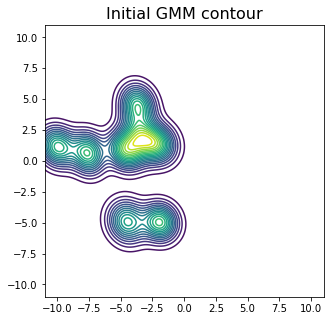

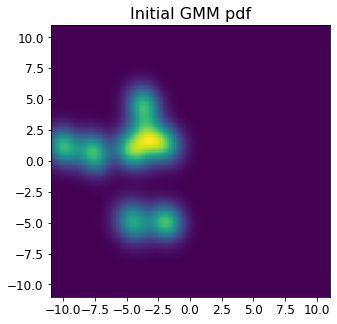

In [164]:
np.random.seed(46)
N_COMPONENTS = 8
gmmEMVar = GMM_VariationalEMFixedPrior(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmmEMVar.gmm_model, 'Initial GMM')

Launch the `variational EM` algo with fixed prior

  0%|          | 0/40 [00:00<?, ?it/s]

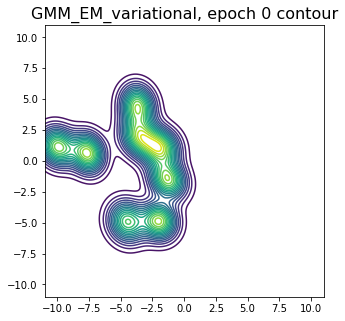

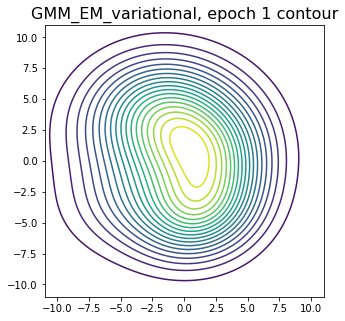

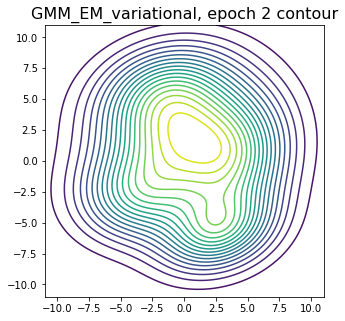

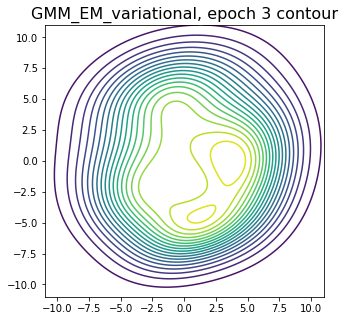

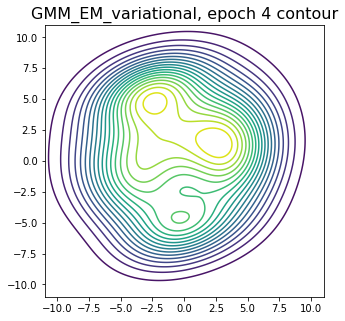

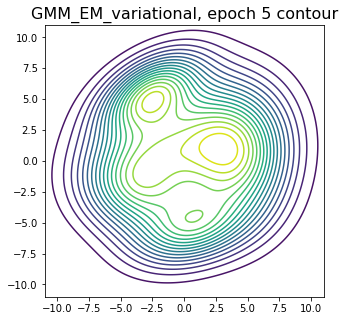

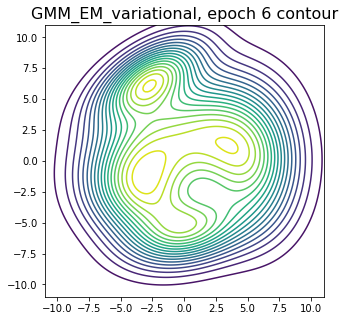

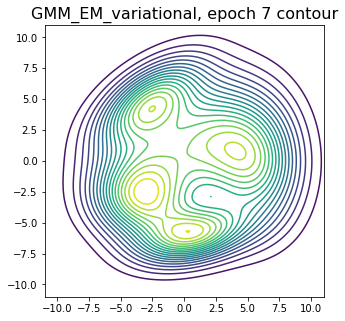

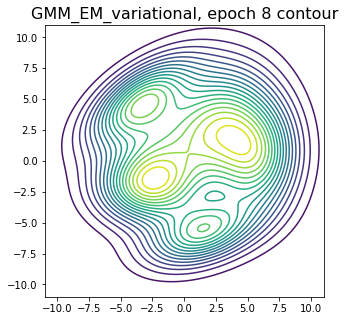

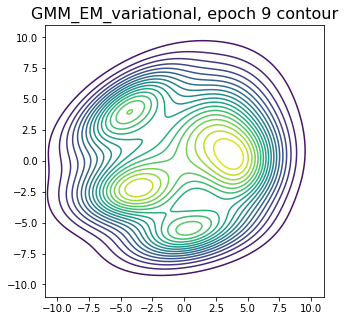

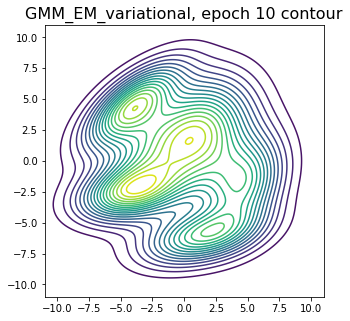

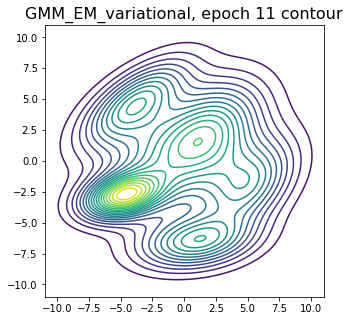

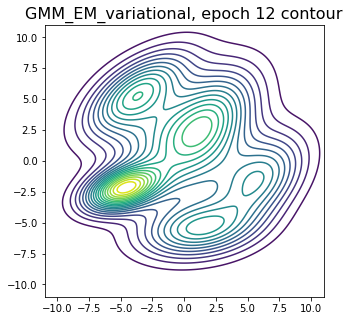

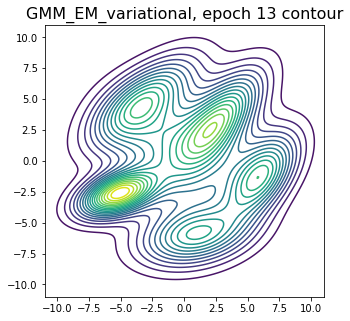

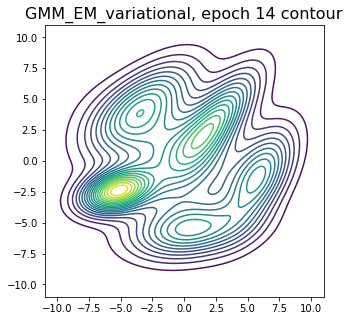

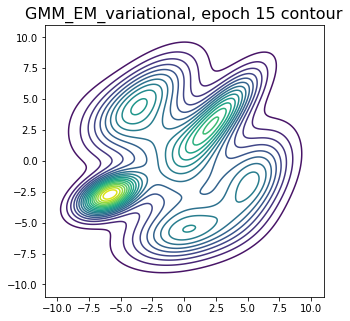

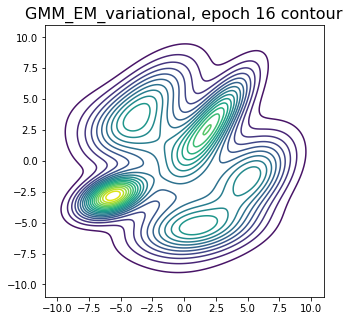

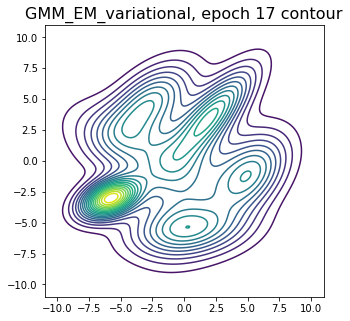

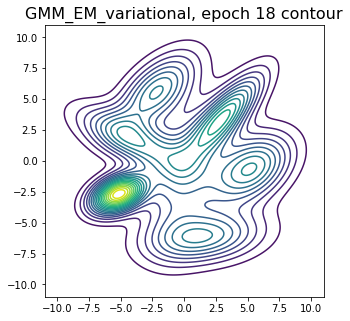

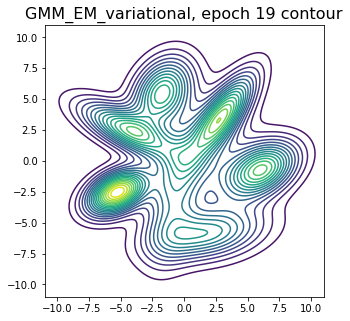

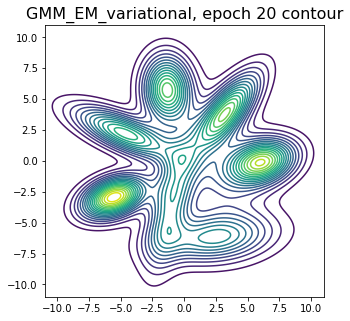

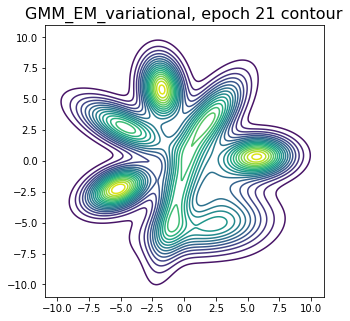

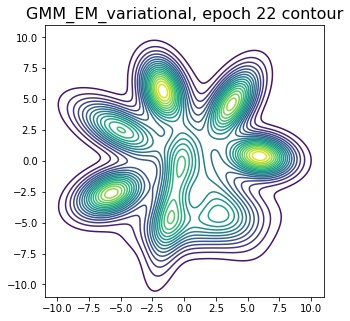

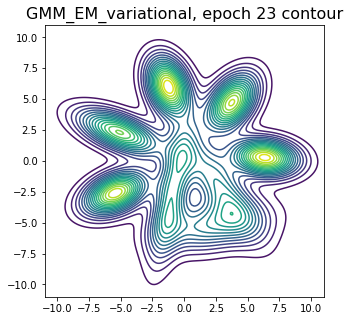

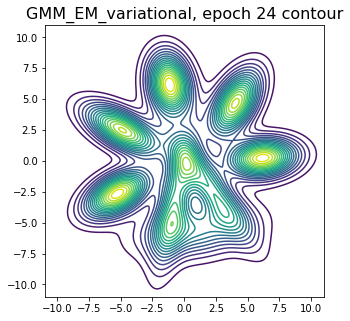

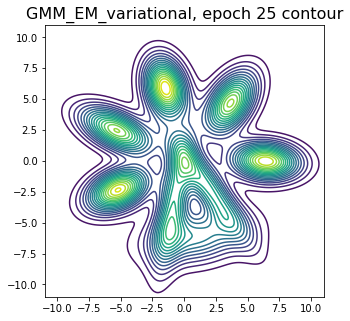

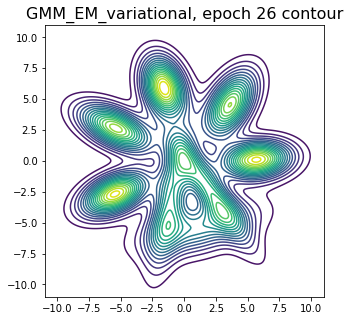

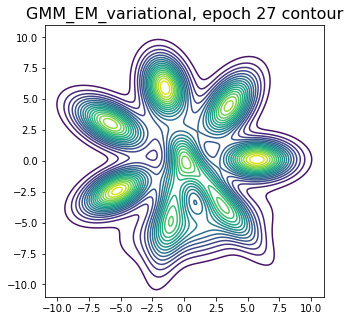

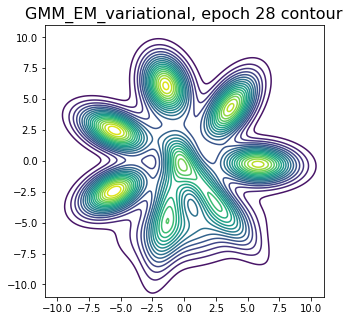

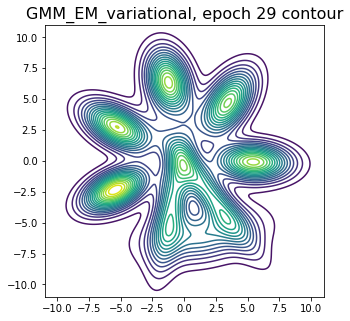

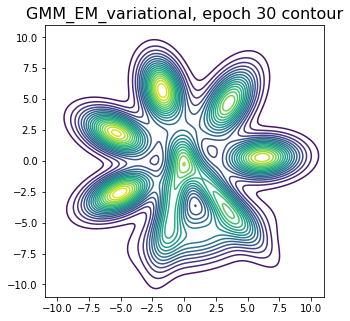

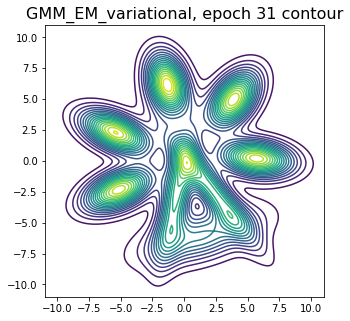

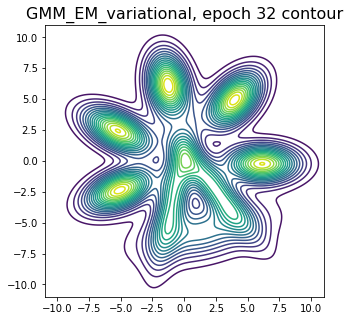

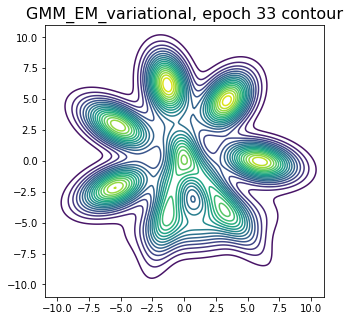

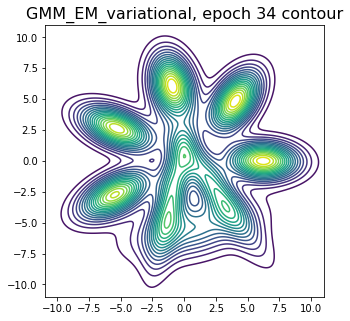

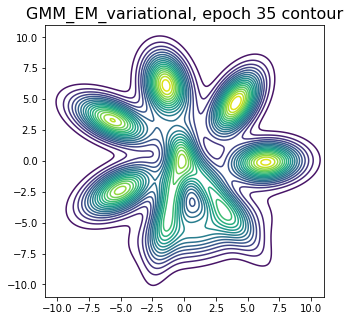

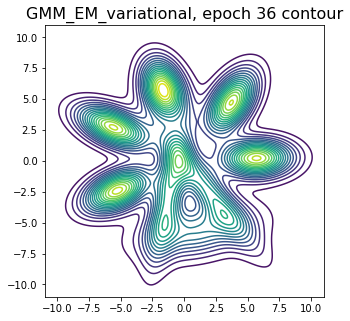

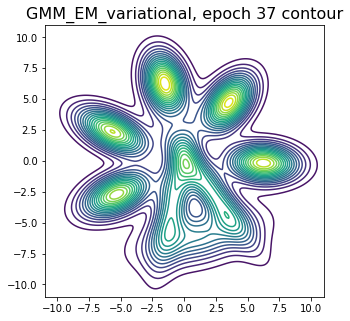

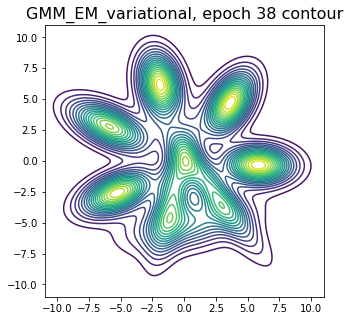

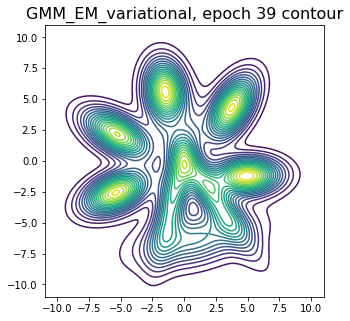

In [165]:
EPOCHS = 40
BATCH_SIZE = 32
Q_LR = 1e-3 # < 1e-2
GMM_LR = 1e-3
E_GRAD_STEPS = 100
M_GRAD_STEPS = 100

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)



train_GMM_VariationalEMFixedPrior(
    gmmEMVar, train_loader, EPOCHS, E_GRAD_STEPS, M_GRAD_STEPS, Q_LR, GMM_LR, use_tqdm=True)

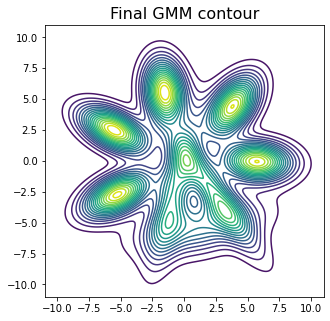

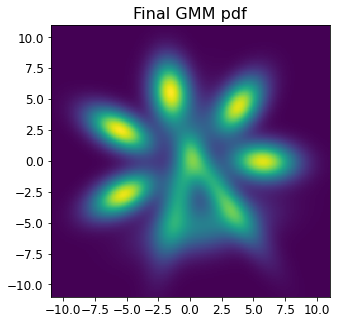

In [166]:
draw_distrib(gmmEMVar.gmm_model, 'Final GMM')

## VAE

<img src="pics/vae-gaussian.png" width=800 height=800 />

$L(q, \theta) = \mathbb{E}_{z \sim q(z| x, \phi)} \ln p(x|z, \theta) - KL(q(z| x, \phi)||p(z))$